Train: C:\machinelearning\epochs\epoch01_front.mkv
Shape:x = (9, 64, 64, 3) y = (9, 1)


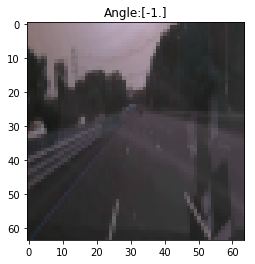

In [49]:
import cv2
import numpy as np
import params,utils

#按批次读取数据
class ImgGenerator():
    def __init__(self,img_path,batch_id,batch_size=None,input_shape=(224,224,3),train_ratio=0.9):
        self.img_path = img_path
        self.batch_id = batch_id
        self.batch_size = batch_size
        self.current_frame = 0
        self.input_shape = input_shape
        self.train_ratio = train_ratio
        
    def next_batch(self):
        #标注处理
        label_all = utils.get_human_steering(self.batch_id)
        if(self.batch_size == None):
            self.batch_size = len(label_all)
            
        label = utils.get_human_steering(self.batch_id)[self.current_frame:self.current_frame+self.batch_size]
        labels = [[label[i]] for i in range(len(label))]
        labels = np.array(labels)
        #图像处理        
        vid_path = utils.join_dir(params.data_dir, 'epoch{:0>2}_front.mkv'.format(self.batch_id))
        print('Train:',vid_path)
        cap = cv2.VideoCapture(vid_path)
        nframe = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) - 2)
        if( (self.current_frame+self.batch_size) > nframe):
            self.batch_size = nframe - self.current_frame
        images = []
        for i in range(self.current_frame,self.current_frame+self.batch_size):
            utils.cv2_goto_frame(cap,i) 
            ret, frame = cap.read()
            if (ret == True):
                shape = frame.shape
                frame = frame[int(shape[0]/3):shape[0]-150, 0:shape[1]]
                frame = cv2.resize(frame, (self.input_shape[0], self.input_shape[1]), interpolation=cv2.INTER_AREA)
                frame = np.resize(frame, (self.input_shape[0], self.input_shape[1], self.input_shape[2]))
                images.append(frame)
                del frame
        images = np.array(images)    
        self.current_frame = utils.cv2_current_frame(cap)
        cap.release()

        return (images[:int(self.batch_size*self.train_ratio)],labels[:int(self.batch_size*self.train_ratio)],
                images[int(self.batch_size*self.train_ratio):],labels[int(self.batch_size*self.train_ratio):])
    
#Test
from matplotlib import pyplot 
%matplotlib inline
img_path = params.data_dir
input_shape=(64, 64, params.FLAGS.img_c)
x_test,y_test,_,_ = ImgGenerator(img_path,'01',batch_size=10,input_shape=input_shape).next_batch()
assert len(x_test)==len(y_test)
index = 8
print('Shape:x =',x_test.shape,'y =',y_test.shape)
pyplot.imshow(x_test[index])
pyplot.title('Angle:'+str(y_test[index]))

In [2]:
#vgg16模型改造
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Input
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Lambda

def vgg16_model(input_shape):
    inputs = Input(shape=input_shape)
    lambda_input = Lambda(lambda x:x/255.-0.5,name='Lambda')(inputs)
    base_model = VGG16(include_top=False, weights='imagenet',input_tensor=lambda_input)
    
    #for layer in base_model.layers:
    #    layer.trainable = False
    
    x = base_model.output
    x = Flatten(name='flatten')(x)
    x = Dense(512, activation='relu', name='fc1')(x)
    x = Dropout(0.8,name='fc1_dropout')(x)
    x = Dense(256, activation='relu', name='fc2')(x)
    x = Dropout(0.8,name='fc2_dropout')(x)
    x = Dense(64, activation='relu', name='fc3')(x)
    x = Dropout(0.8,name='fc3_dropout')(x)
    x = Dense(1,activation='tanh',name='output')(x)
    
    model = Model(inputs,x)
    return model

Using TensorFlow backend.


In [42]:
from keras.models import Model
from keras.layers import Input,Conv2D,Lambda,MaxPooling2D,Flatten,Dense
def nvidia_model(input_shape):
    inputs = Input(shape=input_shape)
    
    x = Lambda(lambda x:x/255,name='Lambda')(inputs)
    
    x = Conv2D(24, (5, 5), activation='relu', padding='same', name='block1_conv1')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    x = Conv2D(36, (5, 5), activation='relu', padding='same', name='block2_conv1')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    
    x = Conv2D(48, (5, 5), activation='relu', padding='same', name='block3_conv1')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1164, activation='relu', name='fc1')(x)
    x = Dense(100, activation='relu', name='fc2')(x)
    x = Dense(50, activation='relu', name='fc3')(x)
    x = Dense(10, activation='relu', name='fc4')(x)
    x = Dense(1,name='output')(x)
    
    model = Model(inputs,x)
    return model

In [62]:
from keras.layers import Sequential,Convolution2D
def nvidia_model2(input_shape):
    model = Sequential()
    model.add(Lambda(lambda x:x/255, input_shape=input_shape))
    model.add(Convolution2D(24,5,5,border_mode='valid', activation='relu', subsample=(2,2)))
    model.add(Convolution2D(36,5,5,border_mode='valid', activation='relu', subsample=(2,2)))
    model.add(Convolution2D(48,5,5,border_mode='valid', activation='relu', subsample=(2,2)))
    model.add(Convolution2D(64,3,3,border_mode='valid', activation='relu', subsample=(1,1)))
    model.add(Convolution2D(64,3,3,border_mode='valid', activation='relu', subsample=(1,1)))
    model.add(Flatten())
    model.add(Dense(1164, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    
    return model

In [63]:
#训练模型
from keras import optimizers
import h5py

img_path = params.data_dir
batch_size = 64
input_shape=(params.FLAGS.img_w, params.FLAGS.img_h, params.FLAGS.img_c)
model = nvidia_model2(input_shape=input_shape)
sgd = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss='mean_squared_error',
               optimizer=adam,
               metrics=['accuracy'])

model.summary()
for epochid in ['01']:
    imggen = ImgGenerator(img_path=img_path,
                     batch_id=epochid,
                     batch_size=batch_size,
                     input_shape=input_shape)
    while True:
        x_train,y_train,x_valid,y_valid = imggen.next_batch()
      
        if(len(x_train) == 0):
            break
        model.fit(x_train, y_train,epochs=10,batch_size=32,validation_data=(x_valid, y_valid),shuffle=True)
    
utils.save_model(model)

C:\anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), padding="valid", activation="relu", strides=(2, 2))`
  """
C:\anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), padding="valid", activation="relu", strides=(2, 2))`
  
C:\anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), padding="valid", activation="relu", strides=(2, 2))`
  import sys
C:\anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="valid", activation="relu", strides=(1, 1))`
  
C:\anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding=

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_5 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 30, 30, 24)        1824      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 13, 13, 36)        21636     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 5, 5, 48)          43248     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 3, 3, 64)          27712     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 1, 1, 64)          36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 64)                0         
__________

Epoch 4/10
57/57 [==============================] - 0s 4ms/step - loss: 0.0462 - acc: 0.1228 - val_loss: 0.0683 - val_acc: 1.0000
Epoch 5/10
57/57 [==============================] - 0s 3ms/step - loss: 0.0570 - acc: 0.1228 - val_loss: 0.1017 - val_acc: 1.0000
Epoch 6/10
57/57 [==============================] - 0s 3ms/step - loss: 0.0405 - acc: 0.1228 - val_loss: 0.1655 - val_acc: 1.0000
Epoch 7/10
57/57 [==============================] - 0s 3ms/step - loss: 0.0303 - acc: 0.1228 - val_loss: 0.2275 - val_acc: 1.0000
Epoch 8/10
57/57 [==============================] - 0s 4ms/step - loss: 0.0314 - acc: 0.0000e+00 - val_loss: 0.2652 - val_acc: 0.0000e+00
Epoch 9/10
57/57 [==============================] - 0s 3ms/step - loss: 0.0342 - acc: 0.0000e+00 - val_loss: 0.2731 - val_acc: 0.0000e+00
Epoch 10/10
57/57 [==============================] - 0s 4ms/step - loss: 0.0337 - acc: 0.0000e+00 - val_loss: 0.2562 - val_acc: 0.0000e+00
Train: C:\machinelearning\epochs\epoch01_front.mkv
Train on 57 sa

Train: C:\machinelearning\epochs\epoch01_front.mkv
Train on 57 samples, validate on 7 samples
Epoch 1/10
57/57 [==============================] - 0s 3ms/step - loss: 20.0250 - acc: 0.0000e+00 - val_loss: 19.5595 - val_acc: 0.0000e+00
Epoch 2/10
57/57 [==============================] - 0s 4ms/step - loss: 19.7692 - acc: 0.0000e+00 - val_loss: 19.2309 - val_acc: 0.0000e+00
Epoch 3/10
57/57 [==============================] - 0s 3ms/step - loss: 19.3650 - acc: 0.0000e+00 - val_loss: 18.6894 - val_acc: 0.0000e+00
Epoch 4/10
57/57 [==============================] - 0s 4ms/step - loss: 18.7004 - acc: 0.0000e+00 - val_loss: 17.7892 - val_acc: 0.0000e+00
Epoch 5/10
57/57 [==============================] - 0s 3ms/step - loss: 17.5901 - acc: 0.0000e+00 - val_loss: 16.2929 - val_acc: 0.0000e+00
Epoch 6/10
57/57 [==============================] - 0s 3ms/step - loss: 15.7698 - acc: 0.0000e+00 - val_loss: 14.0317 - val_acc: 0.0000e+00
Epoch 7/10
57/57 [==============================] - 0s 3ms/step - 

Epoch 7/10
57/57 [==============================] - 0s 4ms/step - loss: 18.6860 - acc: 0.0000e+00 - val_loss: 20.8492 - val_acc: 0.0000e+00
Epoch 8/10
57/57 [==============================] - 0s 4ms/step - loss: 18.3892 - acc: 0.0000e+00 - val_loss: 20.5570 - val_acc: 0.0000e+00
Epoch 9/10
57/57 [==============================] - 0s 4ms/step - loss: 18.1300 - acc: 0.0000e+00 - val_loss: 20.3061 - val_acc: 0.0000e+00
Epoch 10/10
57/57 [==============================] - 0s 4ms/step - loss: 17.9126 - acc: 0.0000e+00 - val_loss: 20.1200 - val_acc: 0.0000e+00
Train: C:\machinelearning\epochs\epoch01_front.mkv
Train on 57 samples, validate on 7 samples
Epoch 1/10
57/57 [==============================] - 0s 3ms/step - loss: 24.6848 - acc: 0.0000e+00 - val_loss: 26.9469 - val_acc: 0.0000e+00
Epoch 2/10
57/57 [==============================] - 0s 4ms/step - loss: 24.5333 - acc: 0.0000e+00 - val_loss: 26.8042 - val_acc: 0.0000e+00
Epoch 3/10
57/57 [==============================] - 0s 4ms/step -

57/57 [==============================] - 0s 3ms/step - loss: 0.8002 - acc: 0.1053 - val_loss: 1.2086 - val_acc: 0.0000e+00
Epoch 4/10
57/57 [==============================] - 0s 3ms/step - loss: 0.7130 - acc: 0.0877 - val_loss: 1.7588 - val_acc: 0.0000e+00
Epoch 5/10
57/57 [==============================] - 0s 4ms/step - loss: 0.7161 - acc: 0.0877 - val_loss: 2.0500 - val_acc: 0.0000e+00
Epoch 6/10
57/57 [==============================] - 0s 3ms/step - loss: 0.7035 - acc: 0.0877 - val_loss: 1.9605 - val_acc: 0.0000e+00
Epoch 7/10
57/57 [==============================] - 0s 4ms/step - loss: 0.6368 - acc: 0.0877 - val_loss: 1.6144 - val_acc: 0.0000e+00
Epoch 8/10
57/57 [==============================] - 0s 3ms/step - loss: 0.5771 - acc: 0.0877 - val_loss: 1.2276 - val_acc: 0.0000e+00
Epoch 9/10
57/57 [==============================] - 0s 4ms/step - loss: 0.5804 - acc: 0.0877 - val_loss: 0.9395 - val_acc: 0.0000e+00
Epoch 10/10
57/57 [==============================] - 0s 4ms/step - loss: 

In [64]:
#测试模型
import params
from sklearn.metrics import r2_score

img_path = params.data_dir
input_shape=(params.FLAGS.img_w, params.FLAGS.img_h, params.FLAGS.img_c)
x_test,y_test,_,_ = ImgGenerator(img_path,'10',batch_size=64,input_shape=input_shape).next_batch()


model = utils.get_model()
y_predict = model.predict(x_test)
print(y_predict,y_test)
score = r2_score(y_test,y_predict)
print('Score:',score)

Train: C:\machinelearning\epochs\epoch10_front.mkv
Model already exists, do you want to reuse? (y/n): y
Model fetched from the disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_5 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 30, 30, 24)        1824      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 13, 13, 36)        21636     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 5, 5, 48)          43248     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 3, 3, 64)          27712     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 1, 1, 64)          36928     
__________

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
rows = pd.read_csv('C:/machinelearning/0130/deep.csv')
y1=list(rows.Loss.values)
x1=range(0,len(y1)) 
y2=list(rows.ValLoss.values)
x2=range(0,len(y2)) 
plt.plot(x1,y1,label='Loss') 
plt.plot(x2,y2,label='Val Loss') 
plt.xlabel('epochs Number') 
plt.ylabel('Loss') 
plt.title('0130') 
plt.legend() 
plt.show() 

nvidia_model 视频01 epochs10  